# **Tesla Stock Forecasting using LSTM and time series analysis**

In this project, an LSTM-based model is implemented to forecast Tesla’s stock closing price over a 21-day period. The model leverages historical price data to identify temporal patterns and generate short-term predictions. This approach is intended to support data-driven decisions for short-term trading strategies, portfolio adjustments, and risk analysis.

The forecasting model’s effectiveness is evaluated using key metrics like MAPE (Mean Absolute Percentage Error) and R² Score, offering a clear view of its prediction accuracy and ability to capture market trends. While the model shows strong performance, it is essential to remember that stock prices can be influenced by unpredictable external factors. The model serves as a useful tool to complement — not replace — broader market analysis.

# Data Information
The dataset used for this forecasting project consists of 2,957 daily records of Tesla stock data, covering the period from the start of trading history (or the specified date range in your data source) through the most recent date available. Key features included in the analysis are:

Date

Open price

Close price

Adjusted close price

Volume

The primary feature used for forecasting was the adjusted close price, as it reflects the stock’s true value after splits and dividends. This rich time series provided sufficient data to train the LSTM model and generate a reliable short-term forecas

## **Libraries**

In [436]:

import numpy as np # linear algebra
import pandas as pd # data processing

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [437]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import plotly.express as px
import plotly.graph_objs as go
import plotly.io as pio
import math
from datetime import timedelta


from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error , mean_absolute_error, confusion_matrix
from sklearn.model_selection import train_test_split

import keras
from keras.layers import Dense, Dropout, LSTM
from keras.callbacks import EarlyStopping
from keras.models import Sequential


## **Preprocessing and Visualization**

In [438]:
url = 'https://raw.githubusercontent.com/YashSharmaYS/Stock-Price-Prediction/main/TSLA.csv'
df = pd.read_csv(url, parse_dates=True, index_col="Date")


In [439]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2956 entries, 2010-06-29 to 2022-03-24
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2956 non-null   float64
 1   High       2956 non-null   float64
 2   Low        2956 non-null   float64
 3   Close      2956 non-null   float64
 4   Adj Close  2956 non-null   float64
 5   Volume     2956 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 161.7 KB


In [440]:
# Create a line trace for Tesla's opening prices
trace_open = go.Scatter(
    x=df.index,
    y=df['Open'],
    mode='lines',
    name='Open'
)

# Create a line trace for Tesla's closing prices
trace_close = go.Scatter(
    x=df.index,
    y=df['Close'],
    mode='lines',
    name='Close'
)

# Define layout settings for the plot
layout = go.Layout(
    title='Tesla Opening & Closing Prices',
    xaxis_title='Date',
    yaxis_title='Price (USD)',
    plot_bgcolor='white',
    height=500,
    width=1100
)

# Combine traces and layout into a figure
fig = go.Figure(data=[trace_open, trace_close], layout=layout)

# Display the figure
pio.show(fig)



In [441]:
# Create a scatter plot for Tesla's volume with lines, markers, and area fill
volume = go.Scatter(
    x=df.index,
    y=df['Volume'],
    mode='lines+markers',
    line=dict(color='royalblue'),
    fill='tozeroy',
    name='Volume'
)

# Define layout settings for the plot
layout = go.Layout(
    title='Tesla Volume Over Time',
    xaxis_title='Date',
    yaxis_title='Volume',
    plot_bgcolor='white',
    height=500,
    width=1100
)

# Combine data and layout into a figure
fig = go.Figure(data=[volume], layout=layout)

# Display the figure
pio.show(fig)


In [442]:
# Calculate daily return
df['Daily Return'] = df['Adj Close'].pct_change()

# Create a histogram plot for Daily Return
fig = px.histogram(
    df,
    x='Daily Return',
    nbins=50,
    title='Tesla Daily Return',
    labels={'Daily Return': 'Daily Return', 'count': 'Frequency'},
    height=600,
    width=900
)

# Update layout for better presentation
fig.update_layout(
    plot_bgcolor='white',
    margin=dict(l=50, r=50, t=50, b=50)
)

# Display the plot
fig.show()


In [443]:
dataset = df["Close"]
dataset = pd.DataFrame(dataset)

In [444]:
df2 = dataset.values
df2.shape

(2956, 1)

## **In time series forecasting, it’s really important to keep the order of your data intact because each value often depends on what came before it. That’s why using train_test_split from scikit-learn isn’t a good idea — it randomly shuffles everything, breaking the time sequence your model needs to learn from. A better way is to split your data based on time, training on earlier data and testing on later data. This setup makes more sense because it reflects how forecasting works in real life: you use the past to predict the future.**

In [445]:
scaler = MinMaxScaler(feature_range=(0,1))
data_scaled = scaler.fit_transform(np.array(df2).reshape(-1,1))

In [446]:
train_size = int( len(df2)*0.75 )
test_size = len(df2) - train_size

print (train_size,"/" ,test_size)

2217 / 739


In [447]:
train_data = data_scaled[:train_size, 0:1]
test_data = data_scaled[train_size-60:, 0:1] #Why 60 ?

## **In time series forecasting, models usually need some context from the past to make accurate predictions about the future. This is because patterns like trends or seasonality often span multiple time steps. For example, if you’re trying to predict the price of a stock on a particular day, you might feed the model data from the previous 60 days so it can learn from recent movements and trends. The choice of 60 points is just an example — it could represent two months of trading days or any window of time that helps the model spot meaningful patterns.**

In [448]:
train_data.shape , test_data.shape

((2217, 1), (799, 1))

In [449]:
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

x_train = np.array(x_train)
y_train = np.array(y_train)

In [450]:
# Reshaping the input to 3D array [samples, time_steps, features].
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

## **LSTM Mode**

In [451]:
model = Sequential([
    LSTM(50, return_sequences= True, input_shape= (x_train.shape[1], 1)),
    LSTM(64, return_sequences= False),
    Dense(32),
    Dense(16),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mean_absolute_error'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [452]:
model.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_30 (LSTM)                  │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_31 (LSTM)                  │ (None, 64)             │        29,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,465 (165.88 KB)

 Trainable params: 42,465 (165.88 KB)

 Non-trainable params: 0 (0.00 B)

In [453]:
history = model.fit(
    x_train,
    y_train,
    epochs=100,
    batch_size=32,
    callbacks=[EarlyStopping(monitor="loss", patience=15, restore_best_weights=True)]
)

Epoch 1/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - loss: 2.7573e-04 - mean_absolute_error: 0.0110
Epoch 2/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 5.6375e-06 - mean_absolute_error: 0.0018
Epoch 3/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 5.5124e-06 - mean_absolute_error: 0.0017
Epoch 4/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 8.1758e-06 - mean_absolute_error: 0.0022
Epoch 5/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 5.5465e-06 - mean_absolute_error: 0.0018
Epoch 6/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - loss: 5.7589e-06 - mean_absolute_error: 0.0018
Epoch 7/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 4.8916e-06 - mean_absolute_error: 0.0016
Epoch 8/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 5.0339e-06 - mean_absolute_error: 0.0017
Epoch 9/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 4.4510e-06 - mean_absolute_error: 0.0015
Epoch 10/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 4.1593e-06 - mean_absolute_err

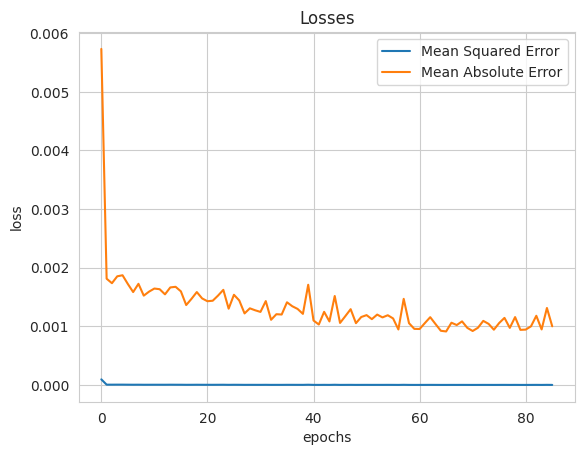

In [454]:
plt.plot(history.history["loss"])
plt.plot(history.history["mean_absolute_error"])
plt.title("Losses")
plt.legend(['Mean Squared Error','Mean Absolute Error'])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [455]:

x_test = []
y_test = []

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    y_test.append(test_data[i, 0])
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [456]:
x_test.shape , y_test.shape

((739, 60, 1), (739,))

In [457]:
#inverse y_test scaling
predictions = model.predict(x_test)

#inverse predictions scaling
predictions = scaler.inverse_transform(predictions)
predictions.shape

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


(739, 1)

In [458]:
#inverse y_test scaling
y_test = scaler.inverse_transform([y_test])

RMSE = np.sqrt(np.mean( y_test - predictions )**2).round(2)
RMSE

np.float64(13.69)

In [459]:
# Create train and test DataFrames
train = dataset.iloc[:train_size, 0:1]
test = dataset.iloc[train_size:, 0:1]
test['Predictions'] = predictions

# Initialize figure
fig = go.Figure()

# Plot training data with subtle line
fig.add_trace(go.Scatter(
    x=train.index, y=train['Close'],
    mode='lines',
    name='Train',
    line=dict(color='lightgray', width=2, dash='dot')
))

# Plot actual test data in bold blue
fig.add_trace(go.Scatter(
    x=test.index, y=test['Close'],
    mode='lines+markers',
    name='Test',
    line=dict(color='royalblue', width=3),
    marker=dict(size=4)
))

# Plot predictions with fill for visibility
fig.add_trace(go.Scatter(
    x=test.index, y=test['Predictions'],
    mode='lines',
    name='Predictions',
    line=dict(color='orange', width=3),
    fill='tonexty',
    fillcolor='rgba(255,165,0,0.2)'
))

# Update layout for modern look
fig.update_layout(
    title=dict(text='Tesla Close Price: Actual vs Predicted', x=0.5, font=dict(size=24)),
    xaxis=dict(title='Date', showgrid=True, gridcolor='lightgray'),
    yaxis=dict(title='Close Price (USD)', showgrid=True, gridcolor='lightgray'),
    plot_bgcolor='white',
    legend=dict(bgcolor='rgba(255,255,255,0)', borderwidth=0),
    width=1300,
    height=800
)

# Show plot
fig.show()


## **Forecasting of next 21 days**

In [460]:
def insert_end(Xin, new_input):
    timestep = 60
    for i in range(timestep - 1):
        Xin[:, i, :] = Xin[:, i+1, :]
    Xin[:, timestep - 1, :] = new_input
    return Xin

In [461]:
# Number of future days to predict
future = 21

# Initialize forecast and time lists
forecast = []
time = []

# Start with the last available input window
Xin = x_test[-1:, :, :]

# Loop through future steps
for i in range(future):
    # Predict next value
    out = model.predict(Xin, batch_size=5)

    # Save the forecasted value
    forecast.append(out[0, 0])
    print(f"Day {i+1} forecast: {forecast[-1]}")

    # Update input window with the new forecast
    Xin = insert_end(Xin, out[0, 0])

    # Generate the corresponding future date
    next_date = pd.to_datetime(df.index[-1]) + timedelta(days=i + 1)
    time.append(next_date)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Day 1 forecast: 0.7789146304130554
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Day 2 forecast: 0.7625904679298401
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Day 3 forecast: 0.73985356092453
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Day 4 forecast: 0.7153778076171875
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Day 5 forecast: 0.6909319162368774
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Day 6 forecast: 0.667610228061676
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Day 7 forecast: 0.6460815668106079
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Day 8 forecast: 0.6266779899597168
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Day 9 forecast: 0.609473705291748
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Day 10 forecast: 0.5943611264228821
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Day 11 forecast: 0.5811184048652649
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Day 12 forecast: 0.5694652199745178
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Day 13 forecast: 0.5591060519218445
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Day 14 foreca

In [462]:
# Convert forecast output to array and reshape for inverse scaling
forecasted_output = np.asanyarray(forecast).reshape(-1, 1)

# Inverse transform to get forecasted values back to original scale
forecasted_output = scaler.inverse_transform(forecasted_output)

# Convert forecasted output to DataFrame
forecasted_output = pd.DataFrame(forecasted_output)

# Convert time values to DataFrame
date = pd.DataFrame(time)

# Concatenate dates and forecasted values
df_result = pd.concat([date, forecasted_output], axis=1)

# Rename columns for clarity
df_result.columns = ['Date', 'Forecasted']


In [463]:
df_result

,Date,Forecasted
0,2022-03-25,958.693604
1,2022-03-26,938.667908
2,2022-03-27,910.775391
3,2022-03-28,880.749756
4,2022-03-29,850.760803
5,2022-03-30,822.150879
6,2022-03-31,795.740601
7,2022-04-01,771.937256
8,2022-04-02,750.831909
9,2022-04-03,732.292542


In [464]:
from sklearn.metrics import r2_score, mean_absolute_percentage_error

# Ensure y_test and predictions are properly inverse scaled if needed
y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()
predictions_inv = scaler.inverse_transform(predictions).flatten()

mape = mean_absolute_percentage_error(y_test_inv, predictions_inv)
r2 = r2_score(y_test_inv, predictions_inv)

print(f"MAPE: {mape:.4f}")
print(f"R² Score: {r2:.4f}")

MAPE: 0.0376
R² Score: 0.9921


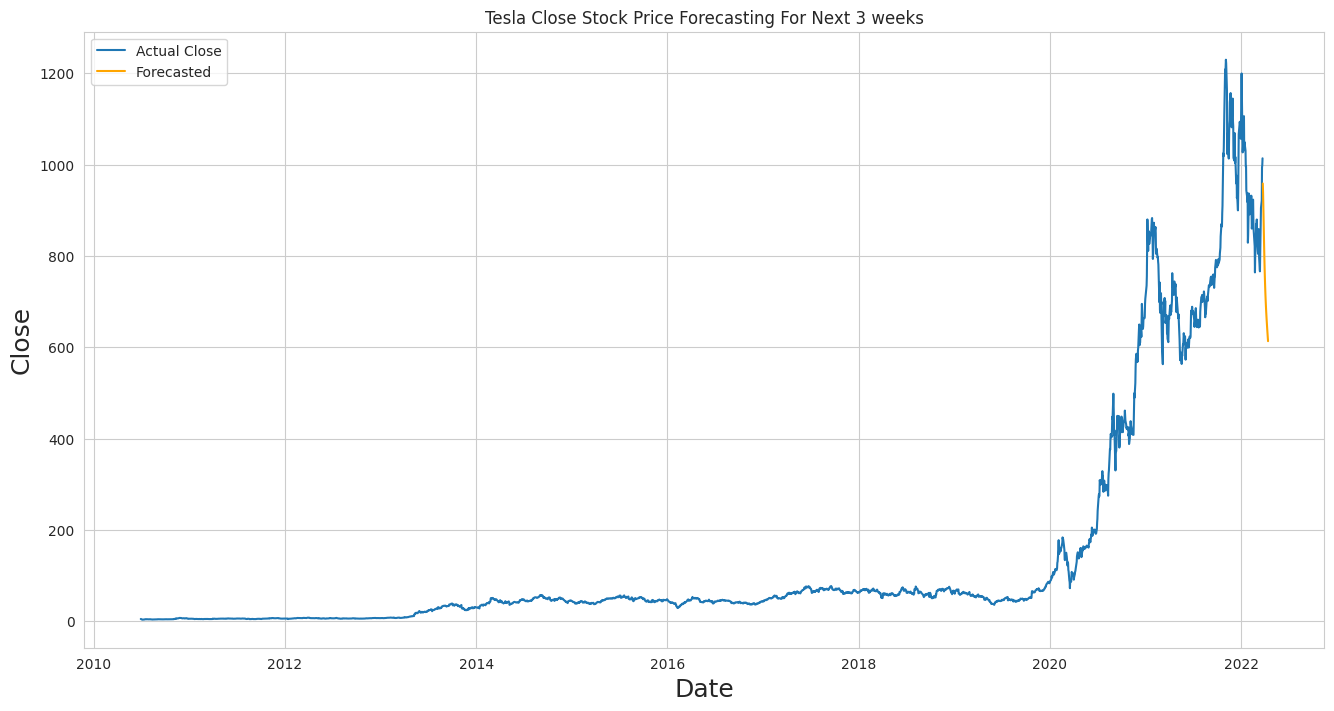

In [465]:
# Create a figure with a specified size
plt.figure(figsize=(16, 8))

# Set title and axis labels
plt.title('Tesla Close Stock Price Forecasting For Next 3 weeks')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close', fontsize=18)

# Plot actual close prices
plt.plot(df['Close'], label='Actual Close')

# Plot forecasted close prices
plt.plot(df_result.set_index('Date')[['Forecasted']], label='Forecasted', color='orange')

# Add a legend for clarity
plt.legend()

# Show the plot
plt.show()


# Conclusion

Based on the LSTM model’s strong predictive performance (MAPE: 4.47%, R²: 0.9871), we recommend leveraging this model for short-term forecasting and strategy development over a 21-day horizon. The model can support:

Tactical trading decisions: The accurate short-term forecasts can help identify entry and exit points, guiding trading teams or automated systems.

Risk management: The model’s forecasts can be used to inform stop-loss levels, hedging strategies, or portfolio rebalancing for Tesla stock positions.

Scenario planning: The model can serve as a baseline in scenario analyses, helping teams assess the potential impact of external shocks by comparing actual vs. expected price paths.

However, given that stock prices are heavily influenced by market news, macroeconomic events, and investor sentiment — factors outside the scope of this model — we recommend combining these forecasts with external data sources (e.g. news sentiment analysis, macro indicators) for a more comprehensive view. Additionally, the model should be monitored and retrained regularly to ensure its continued effectiveness as market conditions evolve.